In [178]:
#Training and applying models for the regression problems using catboost regressor
pip install catboost

In [0]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import datetime as dt
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

In [0]:
#Loading the data
meter_data = pd.read_excel('/content/Bulk Meter Data.xlsx')
weather_data = pd.read_excel('/content/Cape Town Weather.xlsx')

In [257]:
#Inspecting the data frame
meter_data.tail()

,DateTime,Power (kW)
17467,2019-10-12 22:00:00,16.1245
17468,2019-10-12 22:30:00,18.1108
17469,2019-10-12 23:00:00,14.1421
17470,2019-10-12 23:30:00,6.3246
17471,2019-10-13 00:00:00,8.2462


In [258]:
#Inspecting the data frame
weather_data.tail()

,Year,Month,Day,Hour,Minute,Temperature,Relative Humidity,Total Precipitation,Wind Speed,Wind Direction
8755,2019,10,13,19,0,22.04,61,0.0,15.38,163.69
8756,2019,10,13,20,0,21.57,61,0.0,16.18,147.72
8757,2019,10,13,21,0,20.48,65,0.0,12.98,146.31
8758,2019,10,13,22,0,19.33,70,0.0,11.18,146.82
8759,2019,10,13,23,0,18.45,75,0.0,9.50,142.70


In [0]:
#Insert Datetime column at beginning of DF
weather_data.insert(0,'DateTime','')
weather_data['DateTime'] = pd.to_datetime(weather_data[['Year','Month','Day','Hour','Minute']])

In [0]:
#Drop individual columns incorporated into the datetime column
weather_data = weather_data.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'])

In [261]:
#Inspect data types
meter_data.dtypes

DateTime      datetime64[ns]
Power (kW)           float64
dtype: object

In [262]:
#Inspect data types
weather_data.dtypes

DateTime               datetime64[ns]
Temperature                   float64
Relative Humidity               int64
Total Precipitation           float64
Wind Speed                    float64
Wind Direction                float64
dtype: object

In [0]:
#Convert to ensure all columns are datatype float
weather_data['Relative Humidity']=weather_data['Relative Humidity'].astype(float)

In [264]:
#Combine the two dataframes, weather and meter data
combined_df = pd.merge(meter_data, weather_data, how='left', left_on=[meter_data.DateTime.dt.date, meter_data.DateTime.dt.hour],
         right_on=[weather_data.DateTime.dt.date, weather_data.DateTime.dt.hour])
combined_df = combined_df.drop(columns=['key_0', 'key_1', 'DateTime_y'])
combined_df.tail()

,DateTime_x,Power (kW),Temperature,Relative Humidity,Total Precipitation,Wind Speed,Wind Direction
17467,2019-10-12 22:00:00,16.1245,15.96,85.0,0.0,29.78,153.43
17468,2019-10-12 22:30:00,18.1108,15.96,85.0,0.0,29.78,153.43
17469,2019-10-12 23:00:00,14.1421,15.57,86.0,0.0,29.95,152.82
17470,2019-10-12 23:30:00,6.3246,15.57,86.0,0.0,29.95,152.82
17471,2019-10-13 00:00:00,8.2462,15.31,87.0,0.0,30.11,153.74


In [265]:
#Check how many null values we have in combined dataframe
null_value_stats = combined_df.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Power (kW)             56
Total Precipitation    44
dtype: int64

In [0]:
#Fill Nan values using median
meter_data.fillna(meter_data.median(), inplace=True)
weather_data.fillna(weather_data.median(), inplace=True)
#combined_df1 = combined_df.fillna(combined_df.median(),inplace = False)
#combined_df.fillna(-999, inplace=True)
combined_df.fillna(combined_df.median(),inplace = True)
#combined_df.interpolate(inplace = True)

In [0]:
# Date variables
combined_df['month'] = combined_df.DateTime_x.dt.month
#meter_data['year'] = meter_data.DateTime.dt.year
combined_df['dayofweek'] = combined_df.DateTime_x.dt.dayofweek
combined_df['hour'] = combined_df.DateTime_x.dt.hour

In [268]:
#Test df
test_df = weather_data.loc[weather_data.DateTime >= '2019-10-13']
test_df.head()
test_df.shape

(24, 6)

In [269]:
#Check how many null values we have in test dataframe
null_value_stats = test_df.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Series([], dtype: int64)

In [0]:
#Make the Datetime column the index
test_df = test_df.set_index('DateTime')

In [271]:
#Resample the weather dataframe over 30 minutes, as expected in the meter readings
test_df = test_df.resample('30min',closed='right').pad()
test_df.head()
#test_df.shape

,Temperature,Relative Humidity,Total Precipitation,Wind Speed,Wind Direction
DateTime,,,,,
2019-10-13 00:00:00,15.31,87.0,0.0,30.11,153.74
2019-10-13 00:30:00,15.31,87.0,0.0,30.11,153.74
2019-10-13 01:00:00,15.08,88.0,0.0,30.59,153.43
2019-10-13 01:30:00,15.08,88.0,0.0,30.59,153.43
2019-10-13 02:00:00,14.95,88.0,0.0,31.09,151.65


In [0]:
#Reset index of test dataframe
test_df = test_df.reset_index()

In [0]:
# Date variables
test_df['month'] = test_df.DateTime.dt.month
#meter_data['year'] = meter_data.DateTime.dt.year
test_df['dayofweek'] = test_df.DateTime.dt.dayofweek
test_df['hour'] = test_df.DateTime.dt.hour

In [274]:
#Inspect test dataframe
test_df.head()

,DateTime,Temperature,Relative Humidity,Total Precipitation,Wind Speed,Wind Direction,month,dayofweek,hour
0,2019-10-13 00:00:00,15.31,87.0,0.0,30.11,153.74,10,6,0
1,2019-10-13 00:30:00,15.31,87.0,0.0,30.11,153.74,10,6,0
2,2019-10-13 01:00:00,15.08,88.0,0.0,30.59,153.43,10,6,1
3,2019-10-13 01:30:00,15.08,88.0,0.0,30.59,153.43,10,6,1
4,2019-10-13 02:00:00,14.95,88.0,0.0,31.09,151.65,10,6,2


In [0]:
#Drop row for 13 October 2019 from training dataset
combined_df.drop(17471,inplace=True)


In [276]:
#Inspect dataframe
combined_df.head()

,DateTime_x,Power (kW),Temperature,Relative Humidity,Total Precipitation,Wind Speed,Wind Direction,month,dayofweek,hour
0,2018-10-14 00:30:00,10.1980,17.82,65.0,0.0,8.89,148.24,10,6,0
1,2018-10-14 01:00:00,8.2462,17.86,66.0,0.0,6.61,150.64,10,6,1
2,2018-10-14 01:30:00,10.1980,17.86,66.0,0.0,6.61,150.64,10,6,1
3,2018-10-14 02:00:00,12.0000,17.96,66.0,0.0,3.67,168.69,10,6,2
4,2018-10-14 02:30:00,8.9443,17.96,66.0,0.0,3.67,168.69,10,6,2


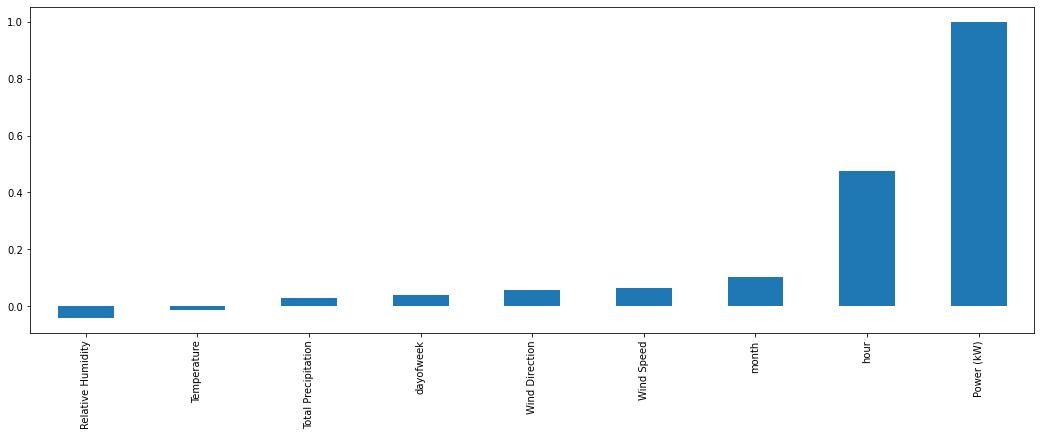

In [277]:
#View correlation between independent variables and dependent variable (Power)
combined_df.corr()['Power (kW)'].sort_values().plot(kind='bar', figsize=(18, 6));

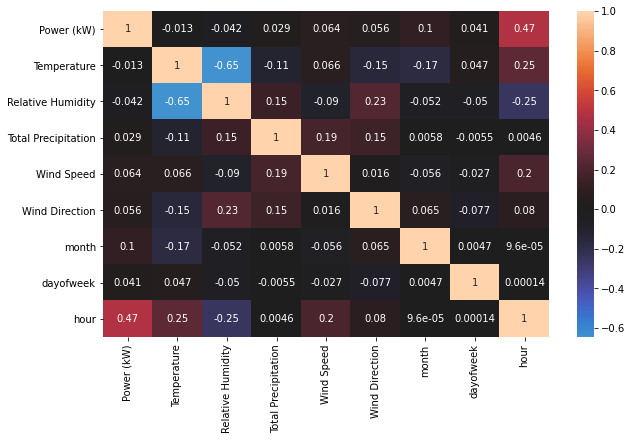

In [278]:
#Correlation amongst features
corr = combined_df.corr()

#Show correlation Matrix as a heatmap
plt.subplots(figsize=(10,6))
sns.heatmap(corr, annot=True, center=0);

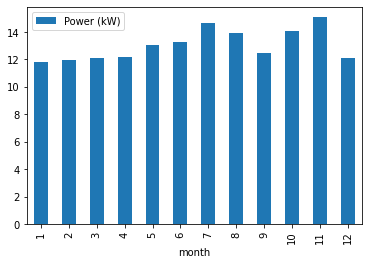

In [279]:
# Plotting mean Power demand for each month - Not much variation in the months
combined_df.groupby('month').mean().reset_index().plot(y='Power (kW)', x='month', kind='bar');

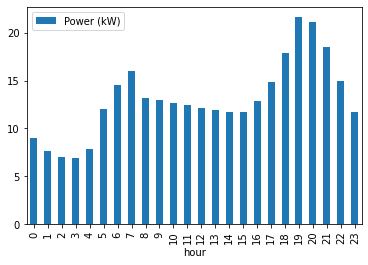

In [280]:
# Plotting mean Power demand for each hour 
combined_df.groupby('hour').mean().reset_index().plot(y='Power (kW)', x='hour', kind='bar');

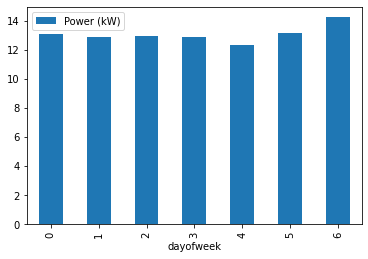

In [281]:
# Plotting mean Power demand for each day of the week - Not much variation in the day of the week
combined_df.groupby('dayofweek').mean().reset_index().plot(y='Power (kW)', x='dayofweek', kind='bar');

In [282]:
#Data Split for Validation: Train - 75%, Test- 25%
train_all = combined_df.copy().dropna()
train = combined_df.loc[combined_df.DateTime_x < '2019-07-14']
test = combined_df.loc[combined_df.DateTime_x >= '2019-07-14']
print(train.shape, test.shape,combined_df.shape,train_all.shape)

(13103, 10) (4368, 10) (17471, 10) (17471, 10)


In [283]:
# Define input and output columns
in_cols = train.columns[2:]
target_col = 'Power (kW)'
in_cols

Index(['Temperature', 'Relative Humidity', 'Total Precipitation', 'Wind Speed',
       'Wind Direction', 'month', 'dayofweek', 'hour'],
      dtype='object')

In [0]:
# Get our X and y training and test sets ready
X_train, y_train = train[in_cols], train[target_col]
X_test, y_test = test[in_cols], test[target_col]

In [285]:
#Train some potential models and evaluate them to choose the best performer based on RMSE and MAE
models = []
models.append(('LiR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))
models.append(('Bag_Re', BaggingRegressor()))
models.append(('RandomForestRegressor', RandomForestRegressor()))
models.append(('ExtraTreesRegressor', ExtraTreesRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVM', SVR()))
models.append(('CatBoost', CatBoostRegressor(verbose = False)))

# Evaluations
results = []
names = []
scoring = []
scores = 20
MAEs = 20
b_model =0

for name, model in models:
    # Fit the model
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    # Evaluate the model
    #RMSE
    score = mean_squared_error(y_test, predictions,squared=False)
    #MAE
    mae = mean_absolute_error(y_test, predictions)
    results.append(mae)
    names.append(name)
    if mae < MAEs and score < scores:
      scores = score
      b_model = name

    msg = "%s: %f (%f)" % (name, score, mae)
    print(msg)
print("\nBest Model: ", b_model, scores)

LiR: 5.715821 (4.607585)
Ridge: 5.715822 (4.607587)
Lasso: 5.722190 (4.558626)
ElasticNet: 5.720485 (4.583813)
Bag_Re: 4.697932 (3.699092)
RandomForestRegressor: 4.614278 (3.632869)
ExtraTreesRegressor: 4.267269 (3.360164)
KNN: 6.229056 (4.887947)
CART: 5.492669 (4.292514)
SVM: 5.862574 (4.526970)
CatBoost: 4.498646 (3.560176)

Best Model:  ExtraTreesRegressor 4.267268836282533


In [286]:
#Use above identified best model to predict on the test dataframe
#Select model
model = ExtraTreesRegressor()
#Fit the model
model.fit(train_all[in_cols], train_all[target_col])


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [0]:
#test_df.head()

In [0]:
#Make predictions from the model
predictions = model.predict(test_df[in_cols])

In [289]:
predictions

array([ 8.3083115,  8.3083115,  8.627421 ,  8.627421 ,  8.349001 ,
        8.349001 ,  8.1527075,  8.1527075,  8.043038 ,  8.043038 ,
        9.8090485,  9.8090485, 12.807241 , 12.807241 , 17.488516 ,
       17.488516 , 18.2176255, 18.2176255, 20.046654 , 20.046654 ,
       16.435639 , 16.435639 , 15.386236 , 15.386236 , 16.6649235,
       16.6649235, 18.633781 , 18.633781 , 18.252535 , 18.252535 ,
       17.8347345, 17.8347345, 16.2548045, 16.2548045, 17.2130515,
       17.2130515, 19.253881 , 19.253881 , 20.9457545, 20.9457545,
       21.7488195, 21.7488195, 22.5062005, 22.5062005, 16.6202885,
       16.6202885, 13.6803665])

In [0]:
#Create dataframe for predicted values
predicted = pd. DataFrame (test_df.DateTime, columns = ['DateTime'])


In [291]:
# Add to prediction dataframe
predicted['Power (kW)'] = predictions
predicted.head()

,DateTime,Power (kW)
0,2019-10-13 00:00:00,8.308311
1,2019-10-13 00:30:00,8.308311
2,2019-10-13 01:00:00,8.627421
3,2019-10-13 01:30:00,8.627421
4,2019-10-13 02:00:00,8.349001


In [0]:
# Save to csv file for submission:
predicted.to_csv('meter_readings_13_10_2019.csv', index=False)

In [293]:
'''
predictions = []
for i in range(10):
  # Training the model with different seeds
  cat = CatBoostRegressor(verbose = False, depth = 9, iterations = 1500, random_seed = i)
  cat.fit(train_all[in_cols], train_all[target_col])

  # Making predictions
  prediction = cat.predict(test_df[in_cols])
  predictions.append(prediction)

# Averaging the predictions
preds = np.mean(predictions, axis = 0)
preds
# Evaluate the model
    #RMSE
#score = mean_squared_error(y_test, predictions,squared=False)
    #MAE
##msg = "%s: %f (%f)" % (name, score, mae)
#print(msg)
'''

'\npredictions = []\nfor i in range(10):\n  # Training the model with different seeds\n  cat = CatBoostRegressor(verbose = False, depth = 9, iterations = 1500, random_seed = i)\n  cat.fit(train_all[in_cols], train_all[target_col])\n\n  # Making predictions\n  prediction = cat.predict(test_df[in_cols])\n  predictions.append(prediction)\n\n# Averaging the predictions\npreds = np.mean(predictions, axis = 0)\npreds\n# Evaluate the model\n    #RMSE\n#score = mean_squared_error(y_test, predictions,squared=False)\n    #MAE\n##msg = "%s: %f (%f)" % (name, score, mae)\n#print(msg)\n'